<a href="https://colab.research.google.com/github/sorayutmild/ENE461_sorayut/blob/main/ENE461_homework3_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Image Enhancement
Description
Write a program for:

 

1) Enhancement of color/gray-scale images by histogram equalization.
Show your output images and histograms comparing to the original image.

 

2) Automatic thresholding of the enhanced image and the original image.

### นายสรยุทธ มียิ้ม ENE 61070502468

## Table of contents:
* [Load and Read the images](#1)
* [ข้อที่ 1 Enhancement of color/gray-scale images by histogram equalization.](#2)
* [ข้อที่ 2 Automatic thresholding of the enhanced image and the original image.](#3)
* [Discussion](#4)

## Load and Read the images <a name='1'></a>

import useful python package

In [32]:
import numpy as np # for work with multi-dimensional array
import matplotlib.pyplot as plt # for Read and write images
import glob # for weorking with files
import os # for weorking with files
import cv2 # for work with image.
import seaborn as sns # for visualization

In [33]:
# create ./test_images path for store the test images.
test_path = './test_images'
if not os.path.exists(test_path):
    os.mkdir(test_path)

Download images from url and save it in ./test_images

the images have come from [freeimages](https://www.freeimages.com//)

In [34]:
import urllib.request

all_image_url = ['https://images.freeimages.com/images/large-previews/b90/amy-lee-1432188.jpg',
                 'https://images.freeimages.com/images/large-previews/35e/woman-with-a-baby-carriage-1491393.jpg']
all_save_name = ['image_1.jpg', 'image_2.jpg'] #local name to be saved

def download_image(all_image_url, all_save_name):
    for idx in range(len(all_image_url)):
        urllib.request.urlretrieve(all_image_url[idx], os.path.join(test_path, all_save_name[idx]))

download_image(all_image_url, all_save_name)

create custom class for read and prettily visualize the images.

In [35]:
class show_images:
    def __init__(self, images_folder_path, ):
        self.images_folder_path = images_folder_path
        self.images_and_names = self.read_all_images()
        self.names = self.read_all_images()['names']

    def read_all_images(self):
        images = []
        names = []
        for img_path in glob.glob(self.images_folder_path+'/*'):
            img = plt.imread(img_path)
            images.append(img)
            names.append(img_path.split('/')[-1])
        images_and_names = {'images':images, 'names':names}
        return images_and_names
    
    def show_images(self, images):
        for idx, img in enumerate(images):
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
            plt.show()
    
    def show_subplot_images(self, images,  nrows=2, ncols=4, figsize=(20,10)):
        plt.figure(figsize=figsize)
        for idx, img in enumerate(images):
            plt.subplot(nrows, ncols, idx+1)
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
        plt.show()
    
    def show_compare_images(self, images1, images2, title1='', title2='', nrows=8,figsize=(10,40)):
        for row, idx in enumerate(range(0, nrows*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(nrows, 2, idx+1)
            plt.axis('off')
            plt.title(title1)
            plt.imshow(images1[row], cmap='gray')

            plt.subplot(nrows, 2, idx+2)
            plt.axis('off')
            plt.title(title2)
            plt.imshow(images2[row], cmap='gray')
            plt.show()

    def show_images_and_hist(self, images, thresholds=[], bins=100, figsize=(20,20)):
        gray_images = self.rgb_to_gray(images)
        for row, idx in enumerate(range(0, len(images)*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(len(images), 2, idx+1)
            plt.axis('off')
            plt.imshow(images[row], cmap='gray')

            plt.subplot(len(images), 2, idx+2)
            # plt.axis('off')
            plt.title(self.names[row])
            plt.xlabel('Intensity')
            plt.ylabel('Number of Pixel')
            plt.hist(gray_images[row].flatten(), bins)
            if len(thresholds) == len(images):
                plt.axvline(thresholds[row], 0, 1, label='pyplot vertical line', color='r')
            plt.show()

    def rgb_to_gray(self, images):
        return [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]


    def gray_to_binary(self, gray_images, thresholds):
        binary_images = []
        for idx, gi in enumerate(gray_images):
            binary_image = np.where(gi < thresholds[idx], 0, 1)
            binary_images.append(binary_image)
        return binary_images

Initilize the class object.

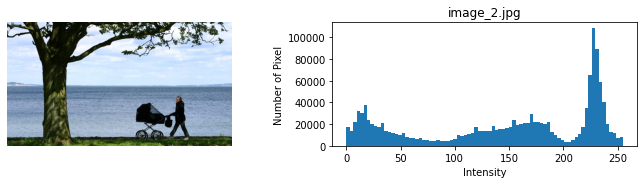

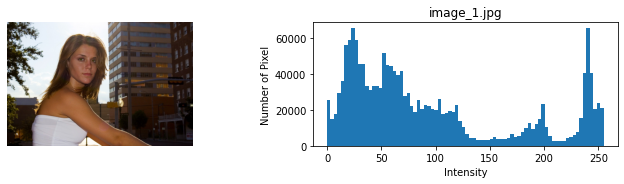

In [36]:
my_cv = show_images(test_path) # input is path where the images is belong.
# show all the images.
images_ori = my_cv.images_and_names['images']
my_cv.show_images_and_hist(images_ori, figsize=(12,5), bins=80)

gray-scale image

In [37]:
gray_images = my_cv.rgb_to_gray(images_ori)

## ข้อที่ 1 Enhancement of color/gray-scale images by histogram equalization. <a name='2'></a>

create function



1.   count_intensity -> For counting number of pixel in each intensity.
2.   cal_pdf -> For Calculating the pdf of image.
3.   cal_cdf -< For Calculating the cdf of image.



In [38]:
def count_intensity(gray_image):
    gray_image = np.concatenate((gray_image.flatten(), np.arange(0, 256))) # for จะได้มีค่าทุก pixel
    unique, counts = np.unique(gray_image, return_counts=True)
    counts = counts - 1 # for delete the value we added.
    # store in dictionary
    results = {'intensity':unique, 'number_of_pixel':counts}
    return results

def cal_pdf(value_in_hist):
    number_of_pixel = value_in_hist['number_of_pixel']
    pdf = number_of_pixel / number_of_pixel.sum()
    return pdf

def cal_cdf(pdf):
    # you can use np.cumsum(pdf) for simply, 
    # but this is for learning purpose
    cdf = []
    t = 0 
    for p in pdf:
        t += p
        cdf.append(t)
    return np.array(cdf) # return as np array type

def adjust_constrast(cdf, image_gray_array):
    return cdf[image_gray_array] * 255 # instead old intensity with cdf

### Histogram Equalization

#### gray-scale image.

In [39]:
# 1. Find Histogram of the image
values_in_hist = [count_intensity(gray_image) for gray_image in gray_images]

# 2. Find Probability Density Function (pdf)
pdf_of_images = [cal_pdf(v) for v in values_in_hist]

# 3. Find Cumulative Distribution Function (cdf)
cdf_of_images = [cal_cdf(p) for p in pdf_of_images]

# 4. Change the gray level
adjusted_images = [adjust_constrast(c, gray_img) for c, gray_img in zip(cdf_of_images, gray_images)]

show pdf and cdf

In [40]:
def show_images_and_pdf_or_cdf(image, pdf_or_cdf, y_axis='', figsize=(15,6)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    # plt.axis('off')
    plt.xlabel('Intensity')
    plt.ylabel(y_axis)
    plt.plot(pdf_or_cdf)

    plt.show()

plot pdf

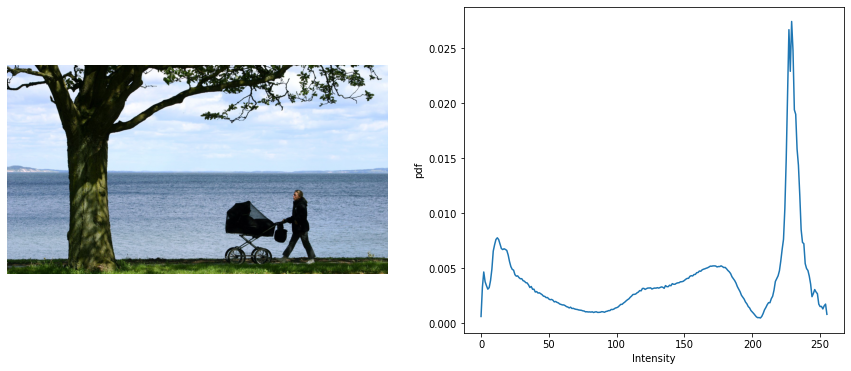

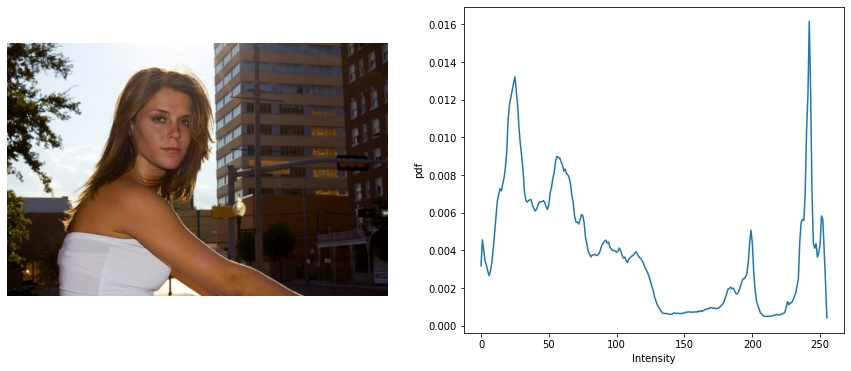

In [41]:
show_images_and_pdf_or_cdf(images_ori[0], pdf_of_images[0], y_axis='pdf')
show_images_and_pdf_or_cdf(images_ori[1], pdf_of_images[1], y_axis='pdf')

plot cdf

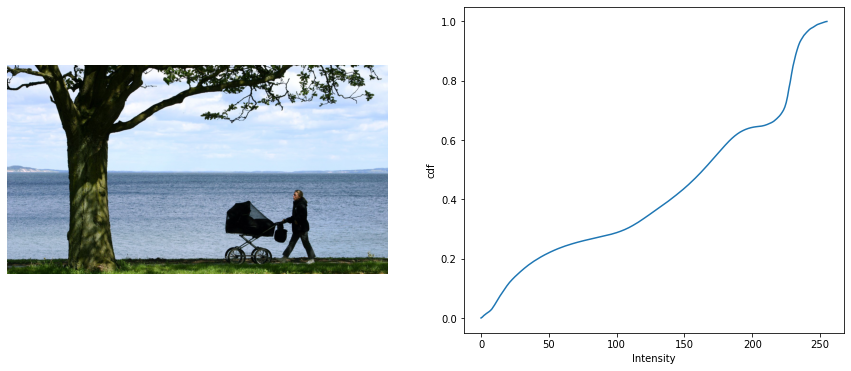

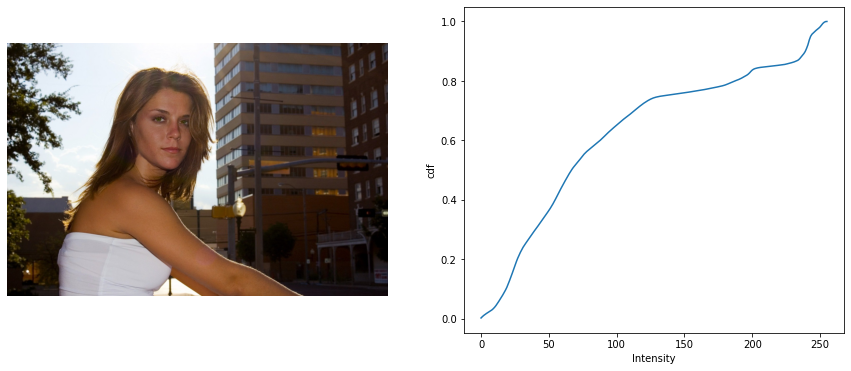

In [42]:
show_images_and_pdf_or_cdf(images_ori[0], cdf_of_images[0], y_axis='cdf')
show_images_and_pdf_or_cdf(images_ori[1], cdf_of_images[1], y_axis='cdf')

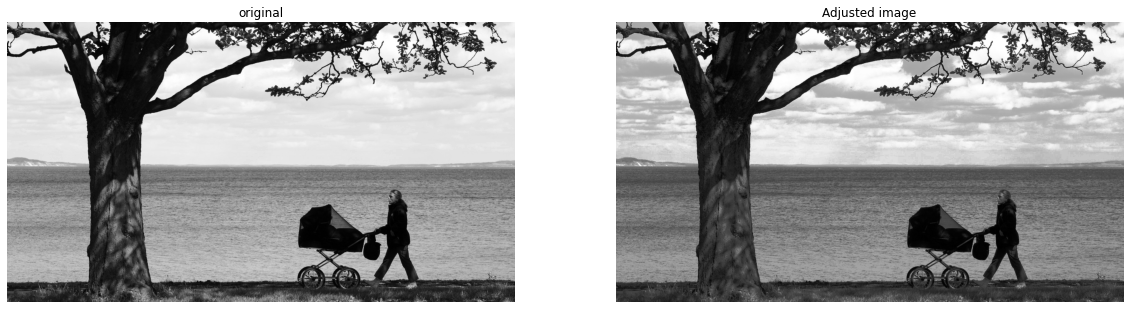

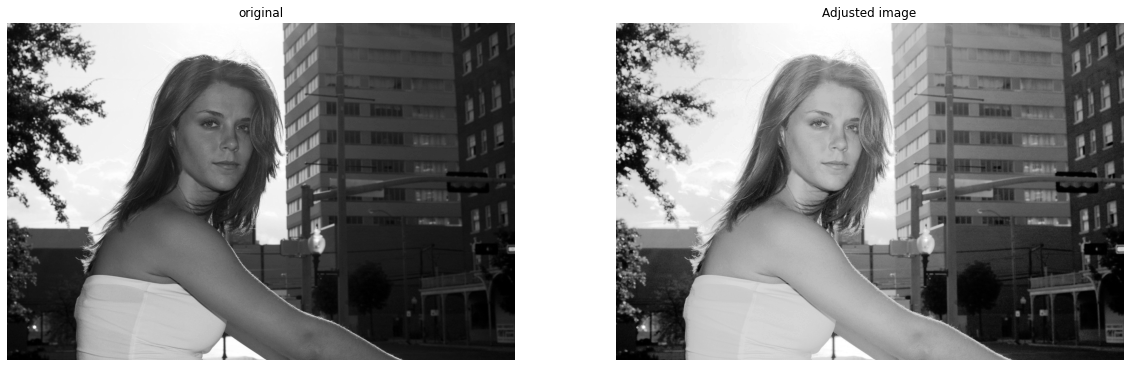

In [43]:
my_cv.show_compare_images(gray_images, adjusted_images, title1='original', title2='Adjusted image', nrows=2, figsize=(20, 20))

Show your output images and histograms comparing to the original image.

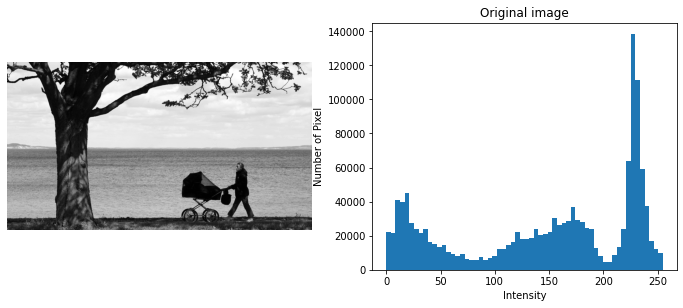

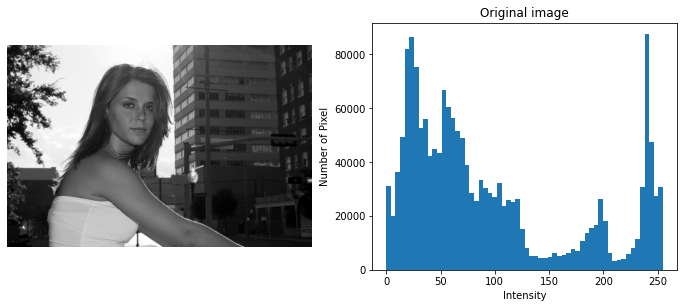

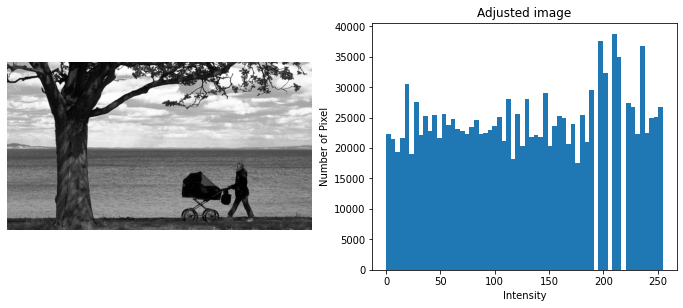

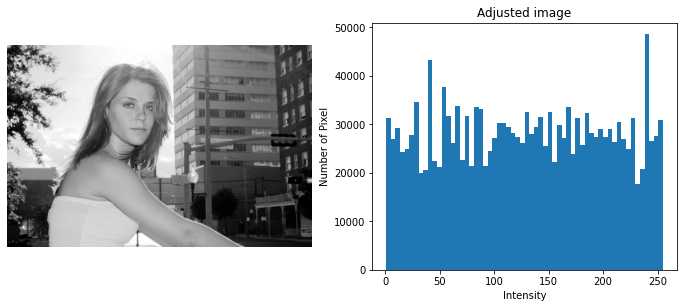

In [44]:
def show_output_and_hist(gray_images, title, bins=60, figsize=(12, 10)):
    for row, idx in enumerate(range(0, len(gray_images)*2, 2)):
        plt.figure(figsize=figsize)
        plt.subplot(len(gray_images), 2, idx+1)
        plt.axis('off')
        plt.imshow(gray_images[row], cmap='gray')

        plt.subplot(len(gray_images), 2, idx+2)
        # plt.axis('off')
        plt.title(title)
        plt.xlabel('Intensity')
        plt.ylabel('Number of Pixel')
        plt.hist(gray_images[row].flatten(), bins)
        plt.show()

show_output_and_hist(gray_images, 'Original image')
show_output_and_hist(adjusted_images, 'Adjusted image')

#### color image

In [45]:
def pipeline(color_channel):
    # 1. Find Histogram of the image
    value_in_hist = count_intensity(color_channel)

    # 2. Find Probability Density Function (pdf)
    pdf_of_image = cal_pdf(value_in_hist)

    # 3. Find Cumulative Distribution Function (cdf)
    cdf_of_images = cal_cdf(pdf_of_image)

    # 4. Change the gray level
    adjusted_image = adjust_constrast(cdf_of_images, color_channel)

    return adjusted_image

def color_histogram_equalization(color_image):
    r = color_image[:, :, 0]
    g = color_image[:, :, 1]
    b = color_image[:, :, 2]

    adjusted_red = pipeline(r)
    adjusted_green = pipeline(g)
    adjusted_blue = pipeline(b)

    return cv2.merge((adjusted_red, adjusted_green, adjusted_blue)).astype(np.uint8)

In [46]:
adjusted_color_images = [color_histogram_equalization(img) for img in images_ori]

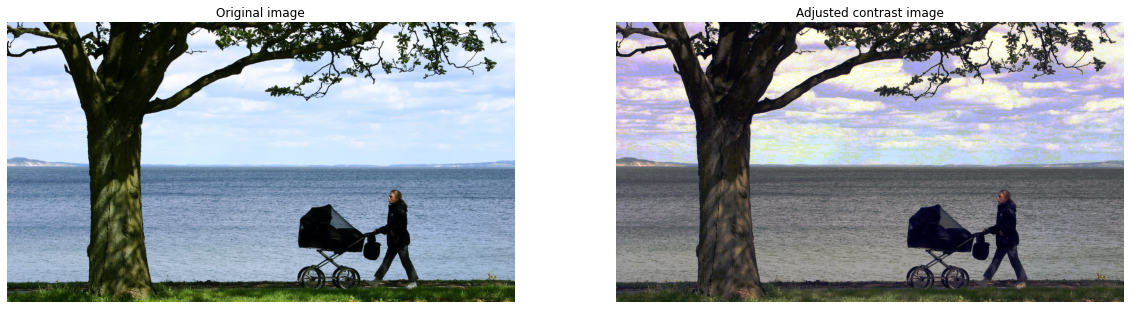

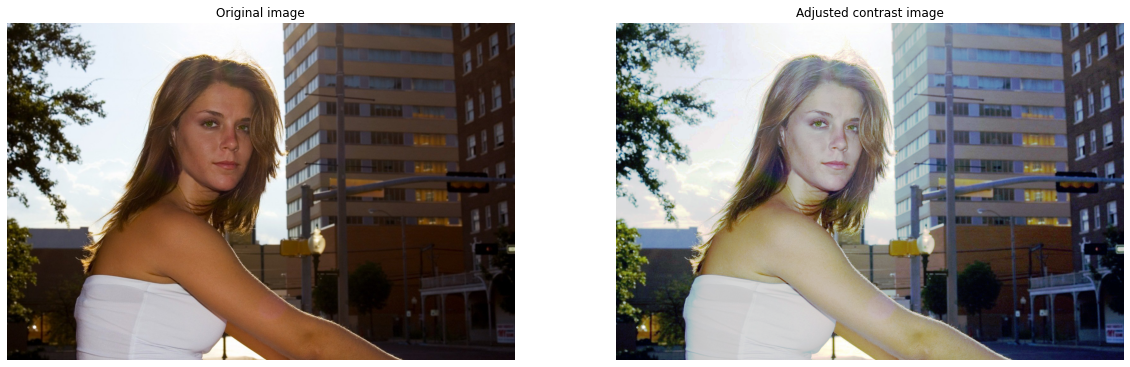

In [47]:
my_cv.show_compare_images(images_ori, adjusted_color_images, title1='Original image', title2='Adjusted contrast image', nrows=2, figsize=(20, 20))

## ข้อที่ 2 Automatic thresholding of the enhanced image and the original image. <a name='3'></a>

Using Average intensities method

In [48]:
def average_intensities_method(image, init_th=100, diff_th=.1, w1=1, w2=1, patience=2):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 1. initial threshold
    th = init_th
    prev_th = 0
    count = 1
    print('init th: ', th, '\n')
    for p, i in enumerate(range(patience)): 
        while abs(th - prev_th) > diff_th:
            # print('iteration: ', count)
            prev_th = th

            # 2. Group 1: I(x,y) >= th => Object. Find avg intensity G1
            G1 = gray_image.copy()[gray_image.copy() >= th] # Object
            G1_mean = G1.mean()
            # print('G1_mean: ', G1_mean)

            # 3. Groip 2: I(x,y) < th => Background. Find avg intensity G2
            G2 = gray_image.copy()[gray_image.copy() < th] # Background
            G2_mean = G2.mean()
            # print('G2_mean: ', G2_mean)

            # 4. Update new th by weighted averaging
            th = (w1*G1_mean + w2*G2_mean) / (w1+w2)
            # print('new_th: ', th, '\n')
            count += 1 
        prev_th = 0 # For patience
        # print('patience: ', p+1)
    return th  

Original images

In [49]:
thresholds = [average_intensities_method(img) for img in images_ori]
thresholds

init th:  100 

init th:  100 



[121.88850380296478, 136.68258617457576]

The adjust threshod is  [122, 137]


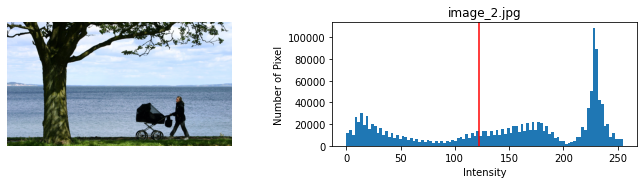

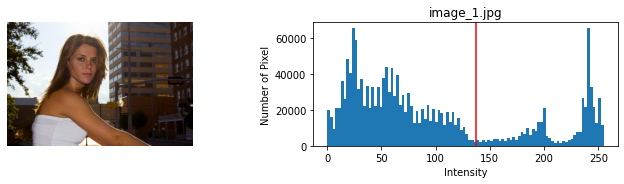

In [50]:
thresholds_rounded = [round(th) for th in thresholds] # round number
print('The adjust threshod is ', thresholds_rounded)
my_cv.show_images_and_hist(images_ori, thresholds=thresholds_rounded, figsize=(12,5))

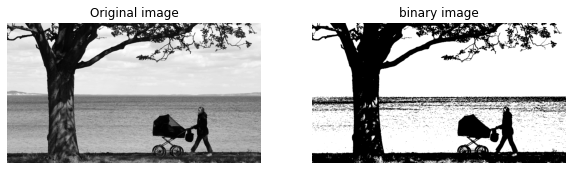

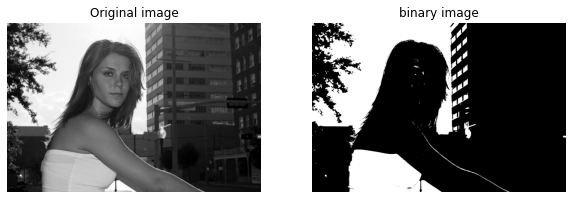

In [51]:
binary_images = my_cv.gray_to_binary(gray_images=gray_images, thresholds=thresholds_rounded)
my_cv.show_compare_images(gray_images, binary_images ,title1='Original image', title2='binary image', nrows=2)

Adjusted images

In [52]:
adjusted_thresholds = [average_intensities_method(img) for img in adjusted_color_images]
adjusted_thresholds

init th:  100 

init th:  100 



[129.56438878252004, 127.90011466558566]

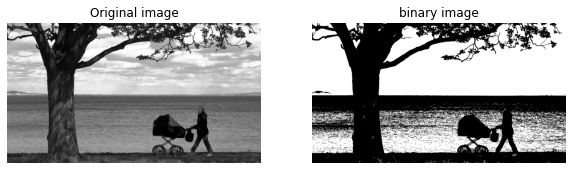

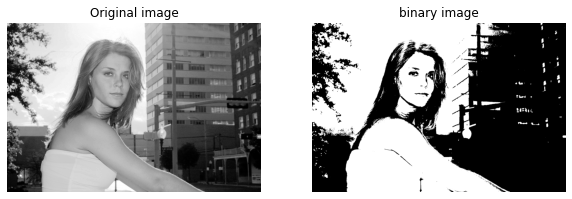

In [53]:
adjusted_binary_images = my_cv.gray_to_binary(gray_images=adjusted_images, thresholds=thresholds_rounded)
my_cv.show_compare_images(adjusted_images, adjusted_binary_images ,title1='Original image', title2='binary image', nrows=2)

## Discussion <a name='4'></a>

พบว่าเมื่อทำการปรับ Contrast โดยใช้่ Histogram Equalization กราฟ histogram จะกระจายตัวมากขึ้น และภาพผลลัพธ์ที่ได้วัตถุแยกชัดกัันมากขึ้น

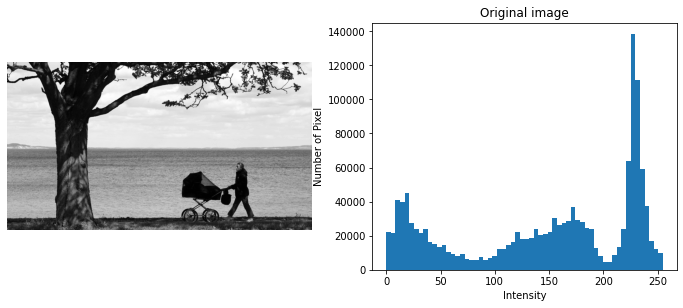

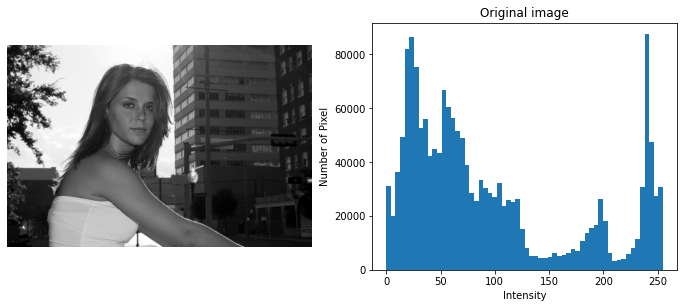

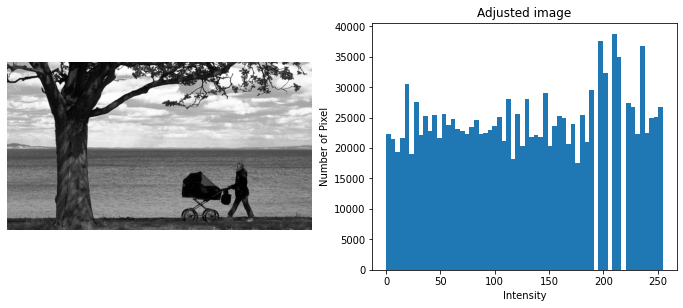

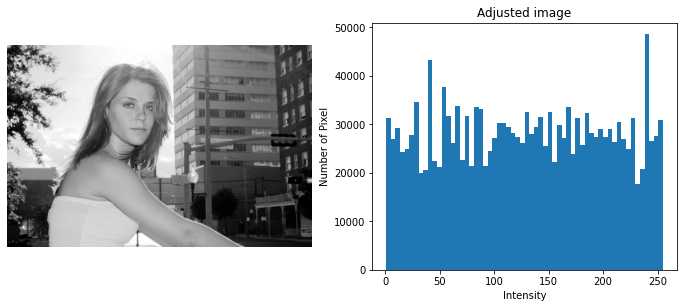

In [54]:
show_output_and_hist(gray_images, 'Original image')
show_output_and_hist(adjusted_images, 'Adjusted image')

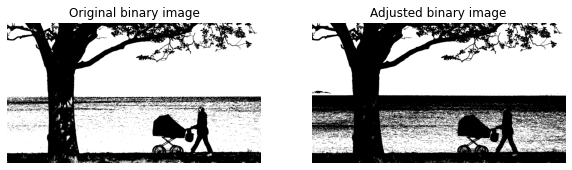

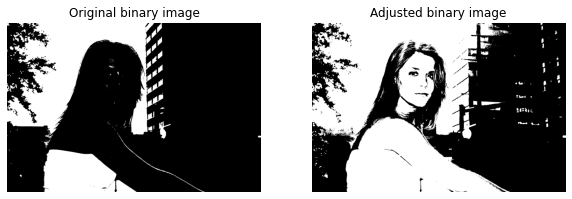

In [55]:
my_cv.show_compare_images(binary_images, adjusted_binary_images, title1='Original binary image', title2='Adjusted binary image', nrows=2)

เหตุผลที่ว่าทำไมถึงใช้ cdf มาใช้ เพราะว่า เราต้องการทำให้ส่วนรูปภาพที่มืด ให้มืดกว่าเดิม และส่วนที่สว่างให้สว่างกว่าเดิม เพื่อให้สามารถแยกชัดได้มากขึ้น และการใช้ cdf เป็นเหมือน transfer fuction ทำให้รูปกระจายตัวมากขึ้น 

In [ ]:
## Convert ipynb to pdf
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!cp '/content/drive/MyDrive/Colab Notebooks/ENE461_homework3_week5.ipynb' .

In [56]:
!jupyter nbconvert --to html "/content/ENE461_homework3_week5.ipynb"

[NbConvertApp] Converting notebook /content/ENE461_homework3_week5.ipynb to html
[NbConvertApp] Writing 5549389 bytes to /content/ENE461_homework3_week5.html
